# VGGNet Architecture

In [9]:
import os
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

### VGGNet model

In [3]:
vggNet = Sequential()

# input layer
vggNet.add(Input(shape=(56, 56, 3)))

# conv block 1
vggNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(MaxPooling2D(pool_size=(2, 2)))

# conv block 2
vggNet.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(MaxPooling2D(pool_size=(2, 2)))

# conv block 3
vggNet.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(MaxPooling2D(pool_size=(2, 2)))

# conv block 4
vggNet.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(MaxPooling2D(pool_size=(2, 2)))

# conv block 5
vggNet.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))
vggNet.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2=5e-4)))
vggNet.add(Activation(activation=relu))

# flatten
vggNet.add(Flatten())

# classifier
vggNet.add(Dense(units=4096))
vggNet.add(Dropout(rate=0.5))
vggNet.add(Dense(units=4096))
vggNet.add(Dropout(rate=0.5))
vggNet.add(Dense(units=42))

vggNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 56, 56, 64)        1792      
                                                                 
 activation_13 (Activation)  (None, 56, 56, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 activation_14 (Activation)  (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 128)       73856     
                                                      

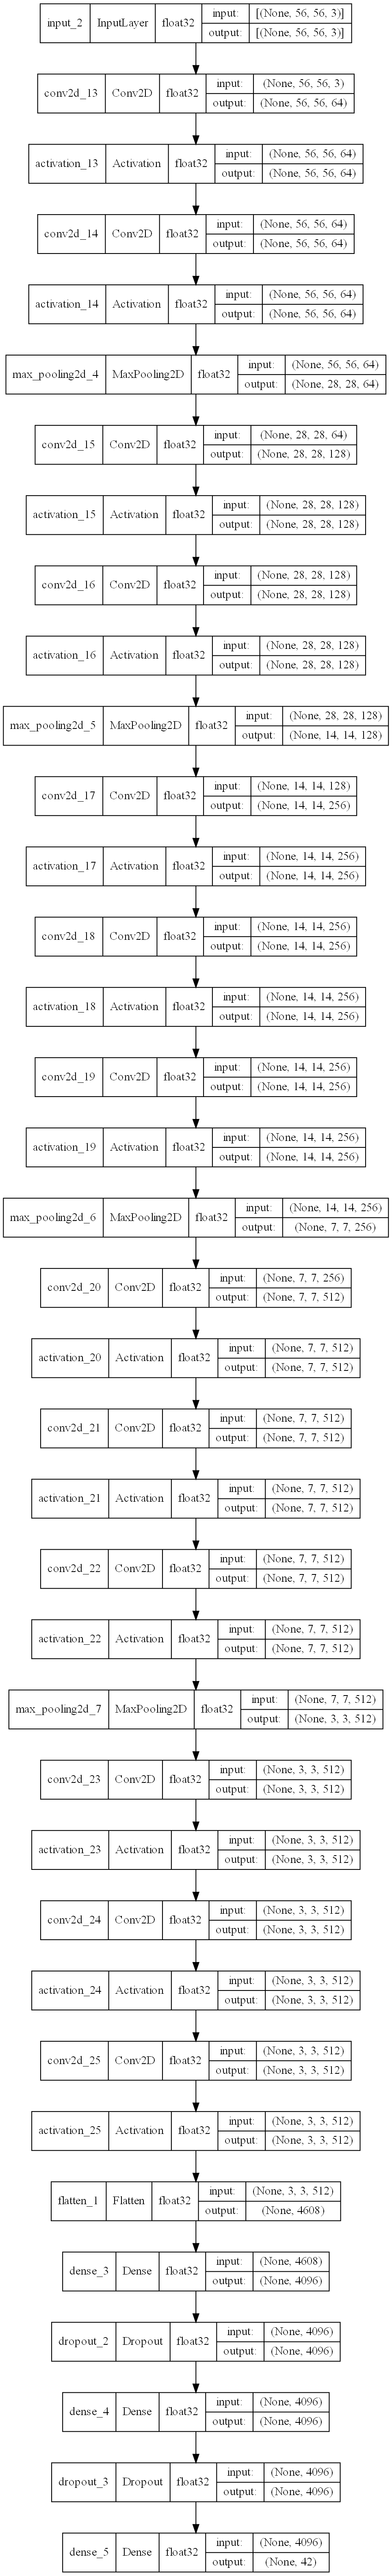

In [4]:
plot_model(model=vggNet,
           to_file='VGGNet.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,
           dpi=150)

In [5]:
tree_types = os.listdir('../../data/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../../data/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(56, 56)))
            X.append(image)
            y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('../../data/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(56, 56)))
            val_x.append(image)
            val_y.append([tree, disease])


In [6]:
X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
generator = ImageDataGenerator(rescale=1. / 255)

In [7]:
X.shape, y.shape, val_x.shape, val_y.shape

((38104, 56, 56, 3), (38104, 42), (9427, 56, 56, 3), (9427, 42))

In [8]:
train_gen = generator.flow(X, y, batch_size=32)
val_gen = generator.flow(val_x, val_y, batch_size=32)

#### training

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='vggNet.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stopping]

In [15]:
vggNet.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                loss=binary_crossentropy,
                metrics=['accuracy'])

In [16]:
leNet_history = vggNet.fit(train_gen,
                            batch_size=32,
                            epochs=90,
                            callbacks=callbacks,
                            validation_data=val_gen)

Epoch 1/90
1218/1218 [==============================] - 89s 70ms/step - loss: 0.2438 - accuracy: 0.1413 - val_loss: 13.4996 - val_accuracy: 0.0215 - lr: 0.0100
Epoch 2/90
1218/1218 [==============================] - 87s 71ms/step - loss: 0.1414 - accuracy: 0.1989 - val_loss: 0.9782 - val_accuracy: 3.1823e-04 - lr: 0.0100
Epoch 3/90
1218/1218 [==============================] - 87s 71ms/step - loss: 0.1269 - accuracy: 0.2299 - val_loss: 1.7811 - val_accuracy: 0.0273 - lr: 0.0100
Epoch 4/90
1218/1218 [==============================] - 97s 79ms/step - loss: 0.1193 - accuracy: 0.2464 - val_loss: 0.1503 - val_accuracy: 0.1639 - lr: 0.0100
Epoch 5/90
1218/1218 [==============================] - 88s 72ms/step - loss: 0.1148 - accuracy: 0.2541 - val_loss: 0.4402 - val_accuracy: 0.0405 - lr: 0.0100
Epoch 6/90
1218/1218 [==============================] - 92s 75ms/step - loss: 0.1115 - accuracy: 0.2630 - val_loss: 0.1138 - val_accuracy: 0.2675 - lr: 0.0100
Epoch 7/90
1218/1218 [===================

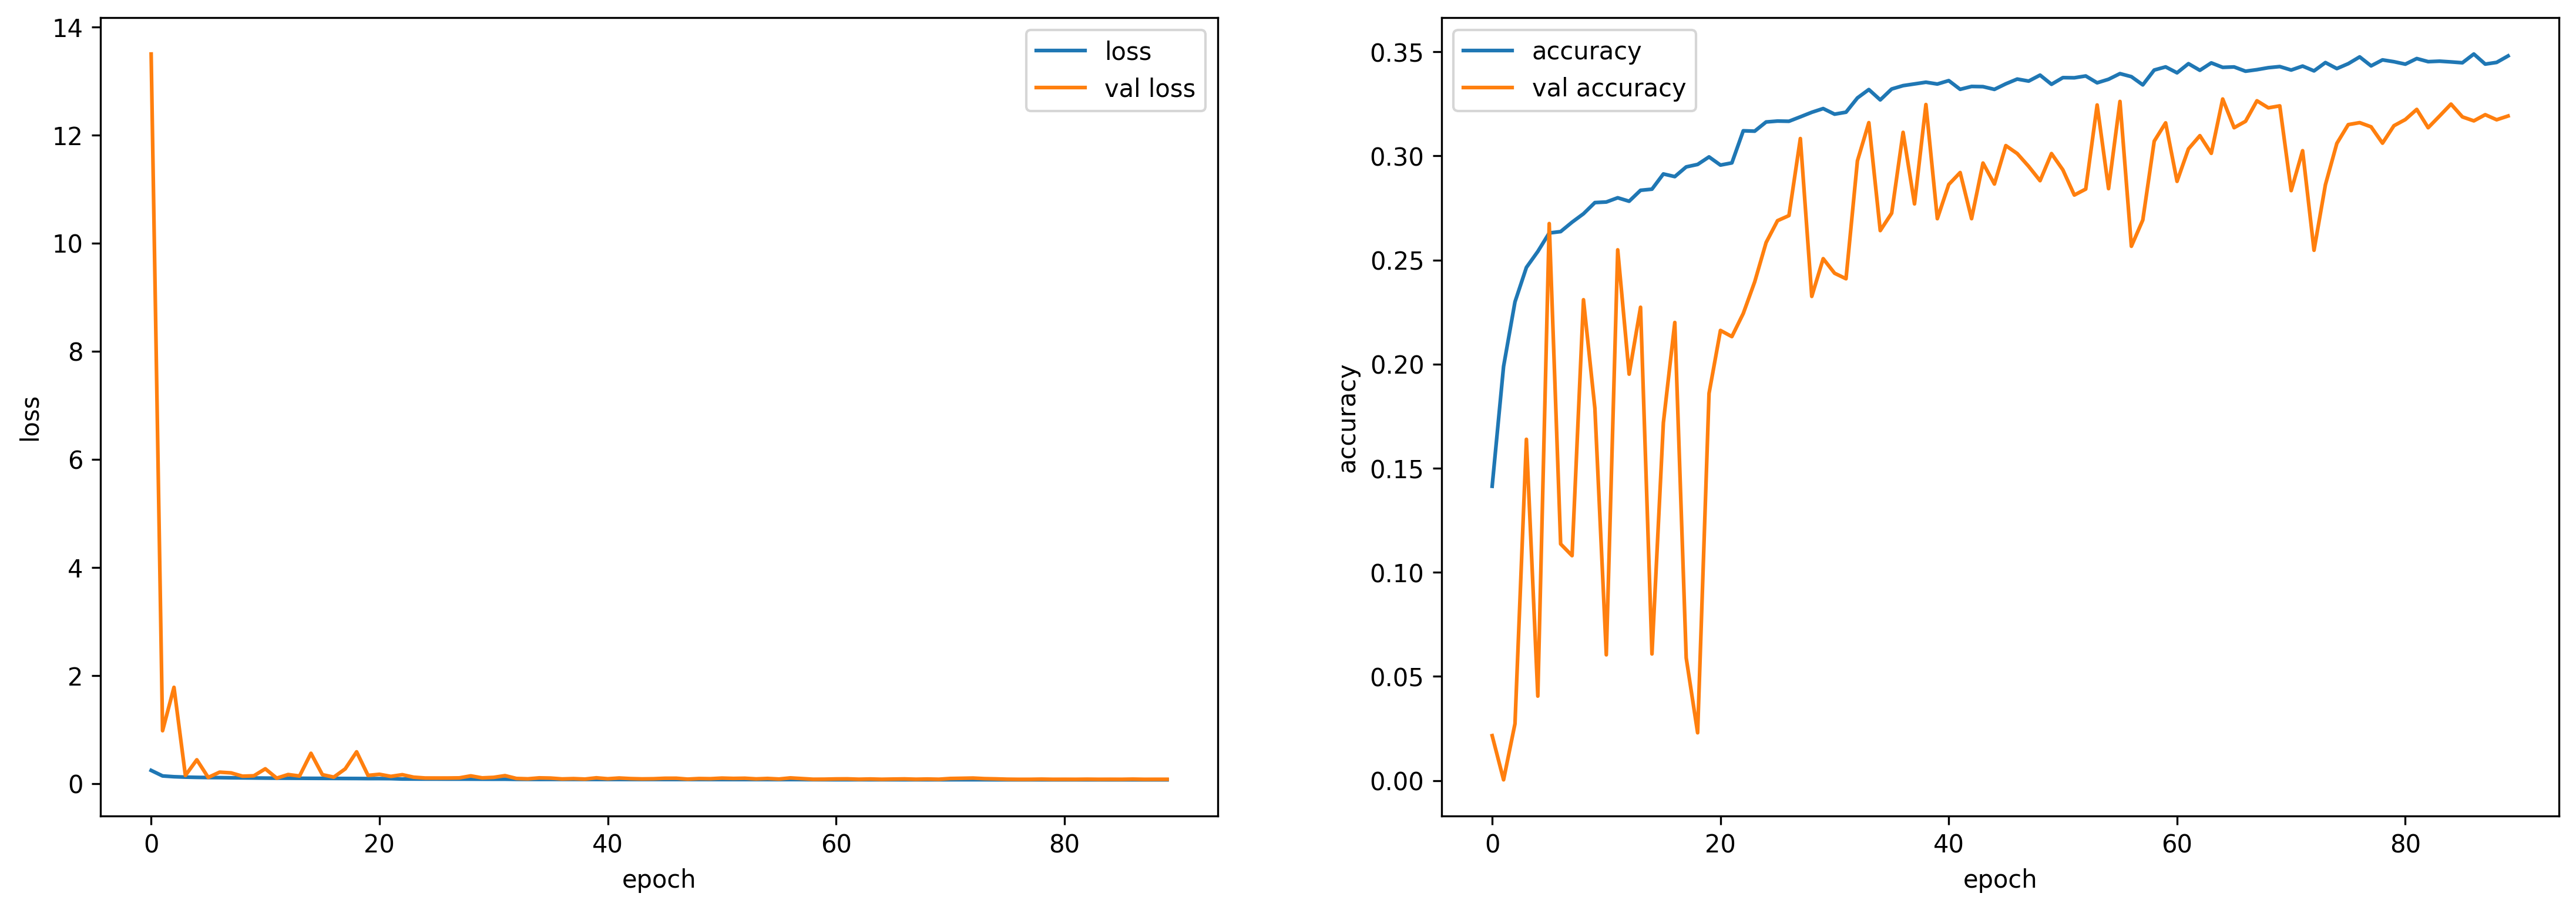

In [17]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(leNet_history.history['loss'])))

sns.lineplot(x=epochs, y=leNet_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=leNet_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=leNet_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=leNet_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('AlexNet_train_history.png')
plt.show()